In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [8]:
lane_change_threshold = 0.25 #lateral offset in meters
turn_threshold = 0.05 #cosine of theta_initial-theta_final
density = 1000
v_max = 0.75

wheel_base, wheel_radius = 0.65, 0.125
noise_x, noise_y, noise_t = 0.0, 0.0, 0.0
tracker_log = None
goal_threshold = 0.05
ref_path = [[0, 0, np.pi/2],[0, 3, np.pi/2],[0.5, 6.0, np.pi/2],
            [0.5, 9.0, np.pi/2],[3.5, 12.0, 0.0],[9.0, 12.0, 0.0]]
# ref_path = [[0, 0, np.pi/2],[0, 10, np.pi/2]]
# ref_path = [[0, 0, np.pi/2],[3, 3, 0]]

init_pose = [0.0, 0.0, np.pi/2]


In [16]:
def simulate_mule(x,y,t, v,w, dt=0.05, noise=0):
    nx,ny,nt = np.random.normal(scale=0.02), np.random.normal(scale=0.02), np.random.normal(scale=0.01)
    return x+v*np.cos(t)*dt+ nx*noise, y+v*np.sin(t)*dt+ny*noise, t+w*dt+nt*noise

In [9]:
class PurePursuitTracker(object):
    def __init__(self, x, y, v, lookahead = 3):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays. v must be a float.
        """
        self.length = len(x)
        self.ppi = 0
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0

    def update(self, x, y, theta):
        """
        Update v, w based on current pose x, y, theta
        Returns True if trajectory is over.
        """
        if (self.ppi + 1 == self.length) and np.hypot(self.x[self.ppi] - x, self.y[self.ppi] - y) < 2: return True
        
        while (np.hypot(self.x[self.ppi] - x, self.y[self.ppi] - y) < self.lookahead) and (self.ppi +1 < self.length):
            self.ppi += 1
                
        anchor = np.asarray([self.x[self.ppi] - x, self.y[self.ppi] - y])
        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        if anchor[0] == 0: self.w = 0
        else: self.w = -self.v / ((anchor[0] ** 2 + anchor[1] **2 ) / (2 * anchor[0]))
        return False

In [10]:
def straight(s, t):
    length = np.linalg.norm(t - s)
    u = (t - s) / length
    z = np.array(
        [s + alpha * u for alpha in np.linspace(0, length, num=int(length * 1000) + 1)]
    )
    return z[:, 0], z[:, 1], np.arctan2(u[1], u[0]) * np.ones_like(z[:, 0])

def turn_theta(alpha, beta, n):
    x = np.linspace(0, 1, num=n)
    return (alpha - beta) * (1 - 3 * x * x + 2 * x * x * x) + beta

def turn(s, u1, t, u2, N=5001):
    ts = t - s
    theta2, theta1 = np.arctan2(u2[1], u2[0]), np.arctan2(u1[1], u1[0])
    if (theta2 - theta1) > np.pi:
        theta2 -= 2 * np.pi
    elif (theta2 - theta1) < -np.pi:
        theta2 += 2 * np.pi
    theta = turn_theta(theta1, theta2, N)
    x, y = np.cumsum(np.cos(theta)), np.cumsum(np.sin(theta))
    rx, ry = ts[0] / x[-1], ts[1] / y[-1]
    return s[0] + rx * x, s[1] + ry * y, theta

def turn_theta_lane(alpha, n):
    x = np.linspace(0, 1, num=n)
    delta = alpha - np.pi / 2
    return np.pi / 2 - np.pi / 2 * (8 * x ** 2 - 16 * x ** 3 + 8 * x ** 4) + delta

def lanechange(s, u, t, N=5001):
    ts = t - s
    alpha = np.arctan2(u[1], u[0]) + 0.001
    theta = turn_theta_lane(alpha, N)
    x, y = np.cumsum(np.cos(theta)), np.cumsum(np.sin(theta))
    rx, ry = ts[0] / x[-1], ts[1] / y[-1]
    return s[0] + rx * x, s[1] + ry * y, theta

def parse(route):
    dense_pathx, dense_pathy, dense_patht = np.array([]), np.array([]), np.array([])
    for p in route:
        px, py, t = dispatch[p[0]](*p[1:])
        dense_pathx = np.concatenate([dense_pathx, px[1:]])
        dense_pathy = np.concatenate([dense_pathy, py[1:]])
        dense_patht = np.concatenate([dense_patht, t[1:]])
    return np.array([dense_pathx, dense_pathy, dense_patht]).T

def convert_to_numpy(path):
    return [[i[0], *map(np.array, i[1:])] for i in path]

dispatch = {
    "straight": straight,
    "turn": turn,
    "lanechange": lanechange,
}

def generate_trajectory(route):
    np_route = convert_to_numpy(route)
    traj = np.array(parse(np_route)).T
    return traj

def find_wps(p1,p2):
    x1, y1, t1 = p1
    x2, y2, t2 = p2
    u1 = [np.cos(t1), np.sin(t1)]
    u2 = [np.cos(t2), np.sin(t2)]
    pos1, pos2 = p1[:-1], p2[:-1]
    if np.isclose(np.dot(u1, u2), 1.0, atol=turn_threshold):
        grad_x, grad_y = np.abs(x1-x2), np.abs(y1-y2)
        lanechange1 = grad_x < grad_y and np.abs(x1-x2) >= lane_change_threshold
        lanechange2 = grad_x > grad_y and np.abs(y1-y2) >= lane_change_threshold
        if lanechange1 or lanechange2:
            return [["lanechange", pos1, u1, pos2]]
        else:
            return [["straight", pos1, pos2]]
    else:
        return [["turn", pos1, u1, pos2, u2]]

def find_complete_trajectory(ref_path):
    dense_pathx, dense_pathy, dense_patht = np.array([]), np.array([]), np.array([])
    for p1, p2 in zip(ref_path[:-1],ref_path[1:]):
        wps = find_wps(p1, p2)
        curr_traj = generate_trajectory(wps)
        xcurr, ycurr, tcurr = curr_traj
        dense_pathx = np.concatenate([dense_pathx, xcurr])
        dense_pathy = np.concatenate([dense_pathy, ycurr])
        dense_patht = np.concatenate([dense_patht, tcurr])
    return np.vstack([dense_pathx, dense_pathy, dense_patht, np.zeros_like(dense_pathx)])

In [14]:
ref_path = np.array([[0, 0, np.pi/2],[0, 3, np.pi/2],[0.5, 6.0, np.pi/2], [0.5, 9.0, np.pi/2],[3.5, 12.0, 0.0],[9.0, 12.0, 0.0]])
x, y, theta, _ = find_complete_trajectory(ref_path)[:, ::50]


In [17]:
tracker = PurePursuitTracker(x, y, 1,1)

xn,yn, tn =0,0, np.pi/2
pose =[]
while True:
    xn,yn,tn = simulate_mule(xn,yn,tn,tracker.v,tracker.w)
    if tracker.update(xn,yn,tn):
        print("ARRIVED!!")    
        break
    pose.append((xn,yn,tn,tracker.v, tracker.w))

ARRIVED!!


<IPython.core.display.Javascript object>


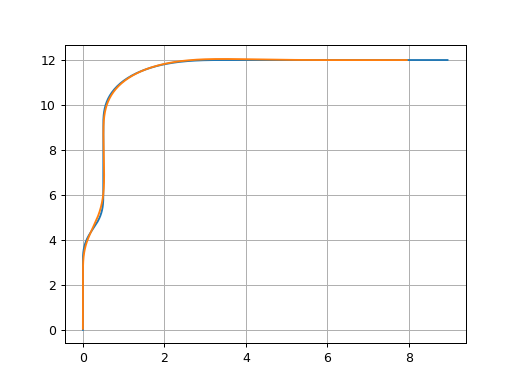

In [18]:
xs,ys,ts,vs,ws = zip(*pose)

plt.figure()
plt.plot(x,y)
plt.plot(xs,ys)
plt.grid()

<IPython.core.display.Javascript object>


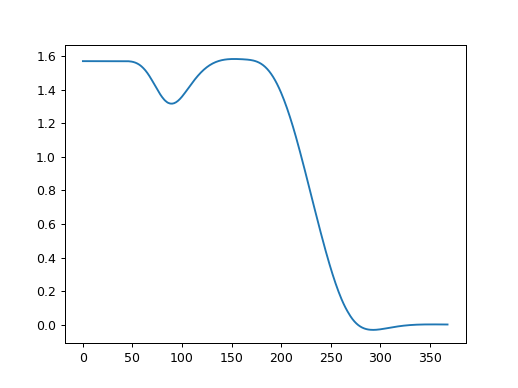

In [19]:
plt.figure()
plt.plot(ts)